In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(23)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


No handles with labels found to put in legend.


Loading (94, 1) (94, 1)


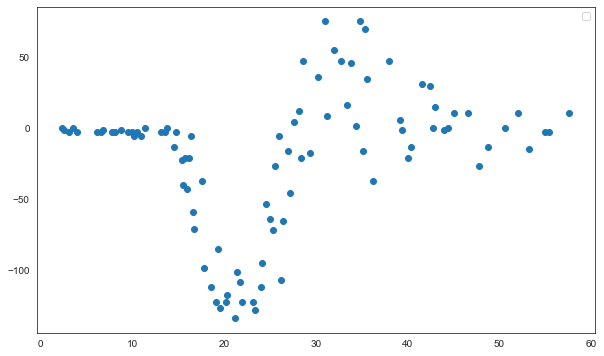

In [3]:
# Loading dataset

data = np.loadtxt('motor.dat')

X_data = data[:, 0][:, None]
y_data = data[:, 1][:, None]

print ('Loading',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X_data,y_data)
ax.legend()
plt.show()

In [4]:
# Shuffling dataset

from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print ('Shuffling',np.shape(X_data_shuff),np.shape(y_data_shuff))

Shuffling (94, 1) (94, 1)


In [5]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print ('Splitting',np.shape(X_train), np.shape(y_train))
print ('Splitting',np.shape(X_test), np.shape(y_test))

Splitting (75, 1) (75, 1)
Splitting (19, 1) (19, 1)


Scaling (75, 1) (75, 1)
Scaling (19, 1) (19, 1)
Scaled(train+test) (94, 1) (94, 1)


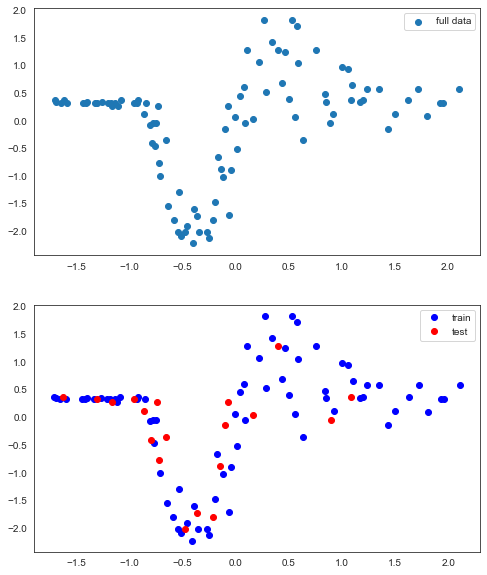

In [6]:
# Scaling dataset

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

print ('Scaling',np.shape(X_train), np.shape(y_train))
print ('Scaling',np.shape(X_test), np.shape(y_test))

#combined data
X_data=np.vstack((X_train,X_test))
y_data=np.vstack((y_train,y_test))

print ('Scaled(train+test)',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.scatter(X_data,y_data,label='full data')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_train,y_train,'bo',label='train')
ax2.plot(X_test,y_test,'ro',label='test')
ax2.legend()
plt.show()

## Pymc model

In [7]:
# Building pymc model

n_hidden = 10

# Initialize random weights between each layer
init_w_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_w_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_w_out = np.random.randn(n_hidden,1).astype(floatX)

init_b_1 = np.random.randn(n_hidden).astype(floatX)
init_b_2 = np.random.randn(n_hidden).astype(floatX)
init_b_out = np.random.randn(1).astype(floatX)


def DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out):
    act_1 = pm.math.tanh(pm.math.dot(x_tensor,weights_in_1)+bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1,weights_1_2)+bias_1_2)
    act_out = pm.math.dot(act_2,weights_2_out)+bias_2_out
    return act_out

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor = theano.shared(y_train)
    x_tensor = theano.shared(X_train)

    #PRIOR
    # Weights and biases from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                             shape=(X_train.shape[1], n_hidden),
                             testval=init_w_1)
    
    bias_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_1)

    # Weights and biases from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_w_2)
  
    bias_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_2)

    # Weights and biases from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                              shape=(n_hidden,1),
                              testval=init_w_out)

    bias_2_out = pm.Normal('b_2_out', 0, sigma=1,
                             shape=(1),
                             testval=init_b_out)
        
    # Build neural-network using activation function
    act_out = DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out)

    # LIKELIHOOD
    out = pm.Normal('out', mu=act_out, sigma=0.1, observed=y_tensor)

In [8]:
X_new = np.linspace(-2.5,2.5,100)[:,None]
print (X_new.shape)

(100, 1)


(5, 100)


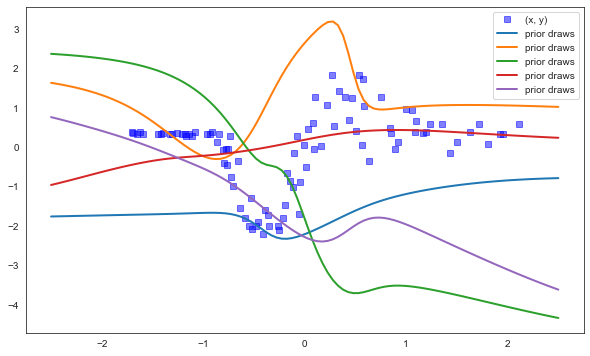

In [9]:
#checking prior draws

with neural_network:
    preds =[DNN(X_new, weights_in_1.random(), bias_in_1.random(), weights_1_2.random(), bias_1_2.random(), weights_2_out.random(), bias_2_out.random()).eval()
     for _ in range(5)]
    preds = np.asarray(preds)
    outputs = preds.reshape(preds.shape[0],preds.shape[1])
    print(np.shape(outputs))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
    ax.plot(X_new,outputs[0].T, lw=2, label='prior draws')
    ax.plot(X_new,outputs[1:].T, lw=2, label='prior draws')
    ax.legend()
    plt.show()

In [10]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## ADVI

In [11]:
# Carrying out ADVI

with neural_network:
#     advi_fit = pm.fit(n=80000, method=pm.ADVI())
    advi_fit = pm.fit(n=80000, method=pm.ADVI(), obj_optimizer = pm.adam())

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 621.66: 100%|██████████| 80000/80000 [01:50<00:00, 721.37it/s] 
Finished [100%]: Average Loss = 621.84


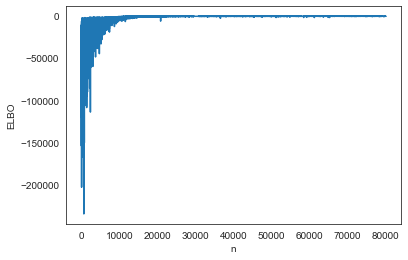

In [12]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Drawing samples

In [13]:
trace = advi_fit.sample(draws=10000)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x130f600b8>],
      dtype=object)

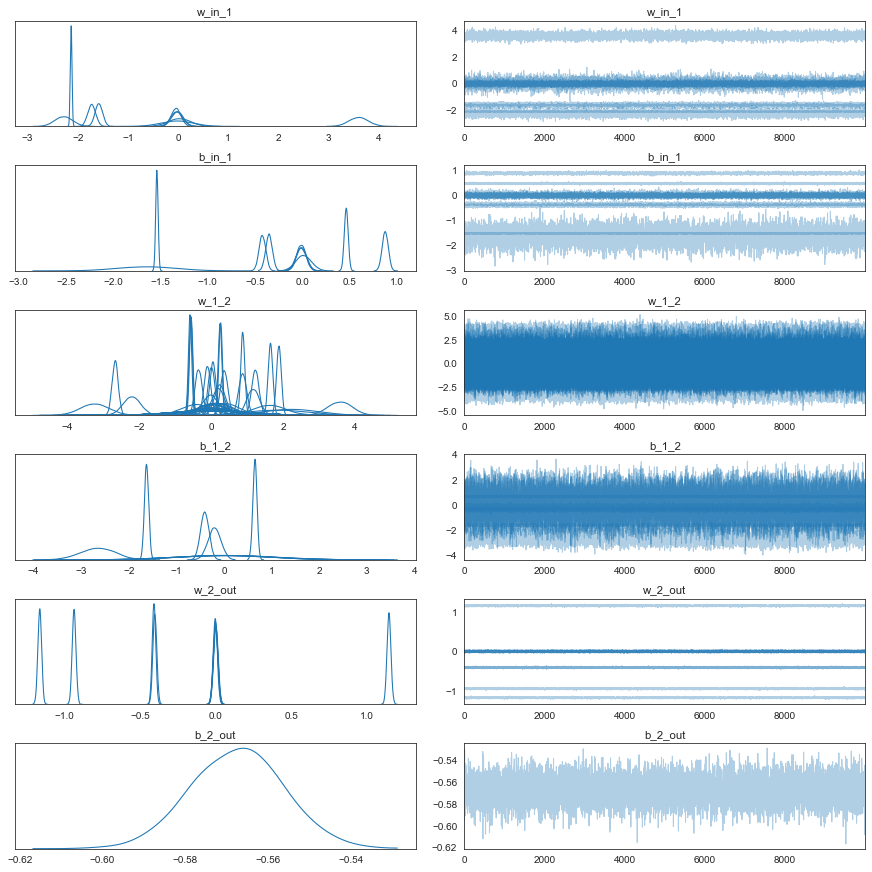

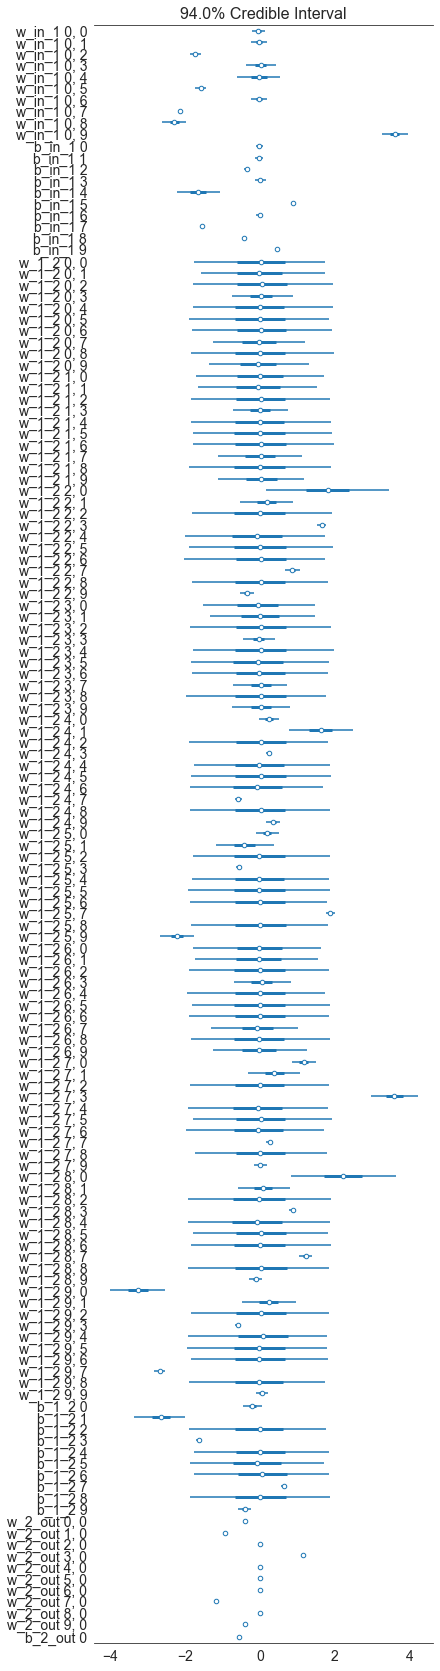

In [14]:
pm.traceplot(trace)
pm.summary(trace)
pm.forestplot(trace)

## Checking

(5, 100)


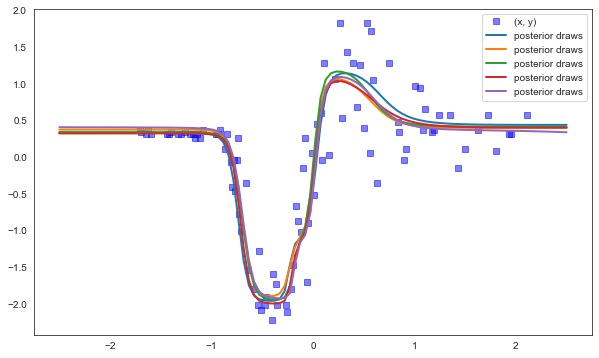

In [15]:
# checking posterior draws

preds =[DNN(X_new, trace['w_in_1'][i], trace['b_in_1'][i], trace['w_1_2'][i], trace['b_1_2'][i], trace['w_2_out'][i], trace['b_2_out'][i]).eval()
 for i in range(5)]
preds = np.asarray(preds)
outputs = preds.reshape(preds.shape[0],preds.shape[1])
print(np.shape(outputs))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(X_data,y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_new,outputs[0].T, lw=2, label='posterior draws')
ax.plot(X_new,outputs[1:].T, lw=2, label='posterior draws')
ax.legend()
plt.show()

## Testing on whole data

In [16]:
# testing on whole data 
x_tensor.set_value(X_new)

In [17]:
posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)

mean_prediction = np.mean(posterior_preds['out'], axis=0)
stddev_prediction = np.std(posterior_preds['out'], axis=0)
print (posterior_preds['out'].shape)

100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]

(1000, 100)


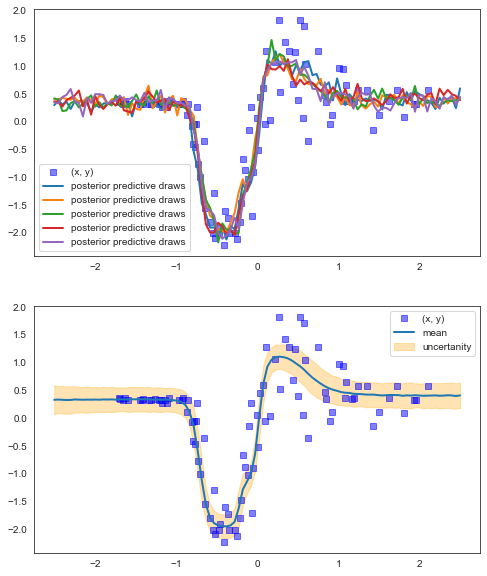

In [18]:
fig = plt.figure(figsize=(8, 10))

ax1 = fig.add_subplot(211)
ax1.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_new, posterior_preds['out'][0] , lw=2, label='posterior predictive draws')
ax1.plot(X_new, posterior_preds['out'][1:5].reshape(4,X_new.shape[0]).T, lw=2, label='posterior predictive draws')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_new, mean_prediction ,lw=2, label='mean')
ax2.fill_between(X_new.ravel(), (mean_prediction-2*stddev_prediction).ravel(), (mean_prediction+2*stddev_prediction).ravel(), alpha = 0.3, color = 'orange',label='uncertanity')
# ax2.errorbar(X_new, mean_prediction, yerr=1.96*stddev_prediction, fmt='o', label='uncertanity', color='red',markersize=4)
ax2.legend()

plt.show()

(10000, 1, 10)


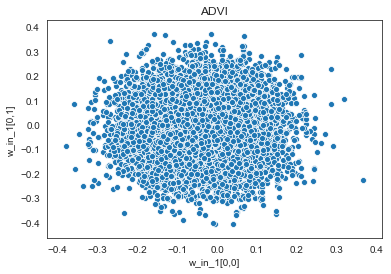

In [19]:
print(trace.get_values('w_in_1').shape)

param_samples_ADVI = pd.DataFrame(
    {'w_in_1[0,0]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,0], 
     'w_in_1[0,1]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,1]})

_ = sns.scatterplot(x='w_in_1[0,0]', y='w_in_1[0,1]', data=param_samples_ADVI).set_title('ADVI')

## Testing on only test data 

100%|██████████| 1000/1000 [00:57<00:00, 17.33it/s]


(1000, 19, 1)
        ADVI    actual  error_ADVI
0  -0.068819 -0.403941    0.335122
1  -1.940354 -1.723242   -0.217112
2  -1.374165 -0.351711   -1.022455
3   0.338115  0.373712   -0.035597
4   0.338584  0.269251    0.069333
5  -1.082280 -0.144723   -0.937556
6   0.462367  0.373712    0.088655
7   1.027859  0.037116    0.990743
8  -0.659135 -0.767619    0.108485
9   0.340288  0.321481    0.018807
10  1.063395  1.280973   -0.217579
11 -1.165836 -0.872080   -0.293756
12  0.534011 -0.042197    0.576208
13 -1.517341 -1.802555    0.285214
14 -1.931567 -2.007608    0.076041
15  0.193429  0.116429    0.077000
16  0.305336  0.321481   -0.016146
17 -0.519603  0.269251   -0.788854
18 -0.999266  0.269251   -1.268517
RMSE for ADVI test predictions = 0.556


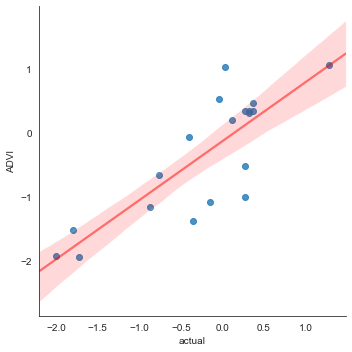

In [20]:
# testing on test data
y_tensor.set_value(y_test)
x_tensor.set_value(X_test)

posterior_preds_test = pm.sample_posterior_predictive(trace, 1000, neural_network)
mean_prediction_test = np.mean(posterior_preds_test['out'], axis=0)
stddev_prediction_test = np.std(posterior_preds_test['out'], axis=0)
print (posterior_preds_test['out'].shape)

prediction_data_test = pd.DataFrame(
    {'ADVI': mean_prediction_test.flatten(), 
     'actual': y_test.flatten(),
     'error_ADVI': (mean_prediction_test - y_test).flatten()})

print (prediction_data_test)

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data_test,
               line_kws={'color': 'red', 'alpha': 0.5})


RMSE = np.sqrt(np.mean(prediction_data_test.error_ADVI ** 2))

print(f'RMSE for ADVI test predictions = {RMSE:.3f}')